In [1]:
from game import *

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

game = GameViewer(target_xyz=None)
x = []
times = []
angles_xy = []
angle_xy, angle_xz = 0, 0

for i in range(300):
    angle_xy+=1
    angle_xz+=1
    target_xyz, score, angle_xy, angle_xz, speed, time = game.tic(angle_xy, angle_xz)
    x.append(target_xyz[0])
    times.append(time)
    angles_xy.append(angle_xy%360)
    game.view()

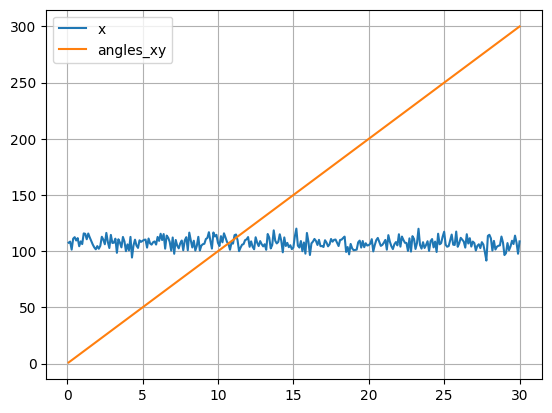

In [3]:
plt.plot(times,x, label='x')
plt.plot(times,angles_xy, label='angles_xy')
plt.grid()
plt.legend()
plt.show()